# This file has a run on prebuilt arch of TADA_T2. Changes are:
1. Final layer dimension
2. Final layer activation
3. Substitution of PADI score in y-axis
4. Change of Loss Function
5. Setting up training loop
6. Examining output differences with reality
7. F1 score
8. Rank and explainability
Compare Rank list


In [24]:
pip install -r /Users/shailshah/Desktop/Aage/TADA_T2/TADA_T2/backend/requirements.txt

     |████████████████████████████████| 11.1 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 21.6 MB/s eta 0:00:01
You should consider upgrading via the '/Users/shailshah/Desktop/Aage/TADA_T2/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model taken from https://github.com/LisaVdB/TADA/blob/main/src/Model.py

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Conv1D, Bidirectional, LSTM, Layer
from tensorflow.keras import regularizers
import keras.backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow import nn, matmul, reduce_sum, constant, keras
import importlib.resources
import tensorflow
from keras import layers, regularizers, metrics, models, optimizers
from keras.losses import SparseCategoricalCrossentropy
# from loss import focal_loss
import matplotlib.pyplot as plt
# from loss import focal_loss

np.random.seed(1258)  # reproducibility

@tf.keras.utils.register_keras_serializable()
class Attention(layers.Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        # Weight matrix for attention
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1),
            initializer="glorot_uniform", trainable=True
        )
        # Bias term
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1),
            initializer="zeros", trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Compute the attention scores
        e = nn.tanh(matmul(inputs, self.W) + self.b)
        # Softmax over the attention scores along the time axis
        a = nn.softmax(e, axis=1)
        # Apply attention weights to the input
        output = inputs * a

        if self.return_sequences:
            return output
        # If not returning sequences, sum the weighted input along the time axis
        return reduce_sum(output, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"return_sequences": self.return_sequences})
        return config

def create_model(SHAPE=(36,42), kernel_size=2, filters=100, activation_function = 'sigmoid', learning_rate=1e-3, dropout=0.3, bilstm_output_size=100):
    """
    Define the NN architecture
    """
    print('Creating model...')
    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     padding='valid',
                     activation=activation_function,
                     strides=1, input_shape = SHAPE,
                     kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)
                    )
                    )

    model.add(Dropout(dropout))
    model.add(Conv1D(filters=filters,
                 kernel_size=kernel_size,
                 padding = 'valid',
                 activation=activation_function,
                 strides=1,
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(dropout))

    model.add(Attention())

    model.add(Bidirectional(LSTM(bilstm_output_size, return_sequences=True))) # Creates Long short term memory RNN and applies a bidirectional wrapper on it
    model.add(Bidirectional(LSTM(bilstm_output_size)))
    # model.add(Dense(2, activation="softmax"))
    model.add(Dense(1, activation='exponential'))  # This is for task 1 and 2. ['linear','polynomial','logarithmic'=exponential]
    opt = Adam(learning_rate=learning_rate)
    # loss_function = focal_loss(alpha = 0.45)

    # model.compile(loss = loss_function,
    #               optimizer = opt,
    #               metrics = metric)
    model.compile(loss='mse', optimizer=opt, metrics=['mae']) # This is for task 4
    return model

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metric = [tf.keras.metrics.Precision(name = 'precision'),
tf.keras.metrics.Recall(name = 'recall'),
tf.keras.metrics.AUC(name = 'auc', curve = 'ROC'),
tf.keras.metrics.CategoricalAccuracy(name ='accuracy'),
tf.keras.metrics.AUC(name = 'aupr', curve = 'PR'),
f1_metric
]

def plot_metric(training_metric, validation_metric, label):
    plt.figure()
    plt.plot(np.arange(1, len(training_metric) + 1), training_metric, label='train', color = "blue")
    plt.plot(np.arange(1, len(training_metric) + 1), validation_metric, label='validation', color = "red")
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.title(label)
    plt.legend()
    plt.savefig('{0}.png'.format(label))

## Get PADI scores in y axis

In [4]:
import os
import numpy as np

# Path to the folder containing the .npz files
folder_path = './pickled_splits'
# /Users/shailshah/Desktop/Aage/TADA_T2/transfer/TADA_T2_Base.ipynb/

# Dictionary to store the loaded data
extracted_data = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.npz'):  # Check if the file has a .npz extension
        file_path = os.path.join(folder_path, file_name)

        # Load the .npz file
        data = np.load(file_path)

        # Store the content in the dictionary
        extracted_data[file_name] = {key: data[key] for key in data.files}

# Print the keys of the extracted data
for file_name, content in extracted_data.items():
    print(f"Extracted from {file_name}: {list(content.keys())}")


Extracted from validation-indices-nosynads.npz: ['arr_0']
Extracted from train-indices-nosynads.npz: ['arr_0']
Extracted from test-indices-nosynads.npz: ['arr_0']
Extracted from test-labels-nosynads.npz: ['arr_0']
Extracted from test-features-scaled-nosynads.npz: ['arr_0']
Extracted from train-features-scaled-nosynads.npz: ['arr_0']
Extracted from validation-features-scaled-nosynads.npz: ['arr_0']
Extracted from validation-labels-nosynads.npz: ['arr_0']
Extracted from train-labels-nosynads.npz: ['arr_0']


In [5]:
dataLoc = "./pickled_splits/"

xTrainNameV1 = "train-features-scaled-nosynads.npz"
yTrainNameV1 = "train-labels-nosynads.npz"
xValNameV1 = "validation-features-scaled-nosynads.npz"
yValNameV1 = "validation-labels-nosynads.npz"
xTestNameV1 = "test-features-scaled-nosynads.npz"
yTestNameV1 = "test-labels-nosynads.npz"

trainIndsNoSynads = "train-indices-nosynads.npz"
valIndsNoSynads = "validation-indices-nosynads.npz"
testIndsNoSynads = "test-indices-nosynads.npz"

scaledFeaturesNoSynadName = "scaled_v1_features.pkl"

In [6]:
xTrainV1 = np.load(dataLoc + xTrainNameV1)['arr_0']
yTrainV1 = np.load(dataLoc + yTrainNameV1)['arr_0']
xValV1 = np.load(dataLoc + xValNameV1)['arr_0']
yValV1 = np.load(dataLoc + yValNameV1)['arr_0']
xTestV1 = np.load(dataLoc + xTestNameV1)['arr_0']
yTestV1 = np.load(dataLoc + yTestNameV1)['arr_0']
xAllV1 = np.append(xTrainV1,xValV1,0)
xAllV1 = np.append(xAllV1,xTestV1,0)
yAllV1 = np.append(yTrainV1,yValV1,0)
yAllV1 = np.append(yAllV1,yTestV1,0)

In [7]:
indsTrainV1 = np.load(dataLoc + trainIndsNoSynads)['arr_0']
indsValV1 = np.load(dataLoc + valIndsNoSynads)['arr_0']
indsTestV1 = np.load(dataLoc + testIndsNoSynads)['arr_0']
indsNoSynads = np.append(indsTrainV1,indsValV1,0)
indsNoSynads = np.append(indsNoSynads,indsTestV1,0)

In [11]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = 'suptable1.xlsx'
data = pd.read_excel(file_path)
data = data.dropna(subset=['PADI Score'])
# Display the first few rows of the data
data.head()

,Sub Library,Fragment Name,Fragment Sequence,Gene Model,ATG Number,Start Position,PADI Score,TF Family,Mean Disorder,AD Subtype,...,CountN,CountP,CountQ,CountR,CountS,CountT,CountV,CountW,CountY,Aromatics
0,Lib1,AT1G01010.1_1,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,AT1G01010.1,AT1G01010,1,1.004699,NAC,0.254442,1.0,...,3,1,1,3,2,1,5,0,1,5
1,Lib1,AT1G01010.1_11,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,AT1G01010.1,AT1G01010,11,0.575876,NAC,0.131235,NaN,...,5,2,0,2,3,1,4,1,2,6
2,Lib1,AT1G01010.1_21,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,AT1G01010.1,AT1G01010,21,-0.300407,NAC,0.104265,NaN,...,4,1,1,4,5,1,3,1,2,6
3,Lib1,AT1G01010.1_31,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,AT1G01010.1,AT1G01010,31,0.105372,NAC,0.105342,NaN,...,2,1,1,5,5,0,3,2,3,9
4,Lib1,AT1G01010.1_41,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,AT1G01010.1,AT1G01010,41,-0.167147,NAC,0.240860,NaN,...,5,1,2,6,5,1,0,2,3,9


### Loci values

In [12]:
import pickle
import pandas as pd

with open('loci_v1.pkl', 'rb') as file:
    loci_v1 = pickle.load(file)

loci_v1 = np.array(loci_v1)

loci_v1

array(['AT1G01010_1', 'AT1G01010_11', 'AT1G01010_21', ...,
       'ATMG00940_111', 'ATMG00940_121', 'ATMG00940_124'], dtype='<U14')

### Subtype values

In [13]:
import pickle
import pandas as pd

with open('subtype_v1.pkl', 'rb') as file:
    subtype_v1 = pickle.load(file)

subtype_v1 = np.array(subtype_v1)

subtype_v1

array([1., 0., 0., ..., 0., 0., 1.])

In [14]:
nameToScore={}
for index, row in data.iterrows():
  name = row['Fragment Name']
  ind = name.find('.')
  name = name[:ind]+name[ind+2:]
  score = row['PADI Score']
  nameToScore[name] = score

In [15]:
nameToScore["AT1G01010_1"]

1.00469864486153

In [16]:
padiScoreV1 = []
for i in loci_v1:
  if i in nameToScore:
    padiScoreV1.append(nameToScore[i])

padiScoreV1[0]

1.00469864486153

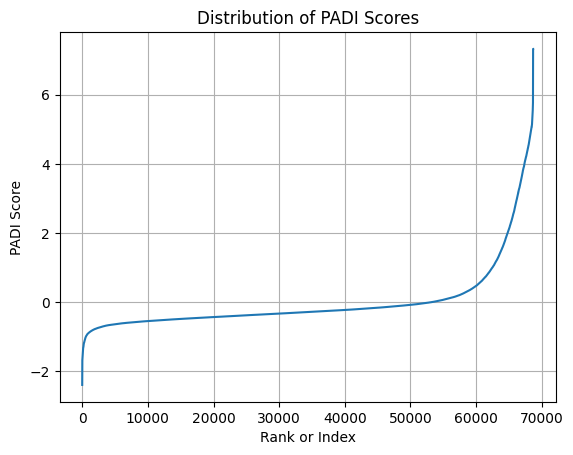

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming padiScoreV1 is your array of PADI scores

# 1. Sort the PADI scores
sorted_padi_scores = np.sort(padiScoreV1)

# 2. Create the x-axis values (ranks or indices)
x_values = np.arange(len(sorted_padi_scores))

# 3. Plot the curve
plt.plot(x_values, sorted_padi_scores)
plt.xlabel("Rank or Index")
plt.ylabel("PADI Score")
plt.title("Distribution of PADI Scores")
plt.grid(True)
plt.show()

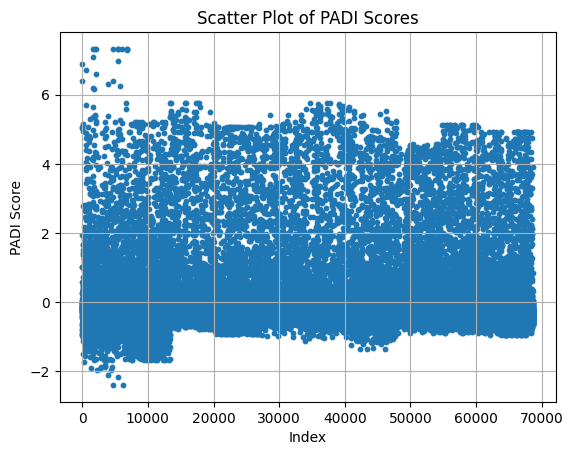

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming padiScoreV1 is your array of PADI scores

# 1. Create x-axis values (indices)
x_values = np.arange(len(padiScoreV1))

# 2. Create the scatter plot
plt.scatter(x_values, padiScoreV1, marker='o', s=10)  # 'o' for circle markers, s for size
plt.xlabel("Index")
plt.ylabel("PADI Score")
plt.title("Scatter Plot of PADI Scores")
plt.grid(True)
plt.show()

<ipython-input-22-fca5a6e3ff4e>:9: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density = kde.gaussian_kde(padiScoreV1)


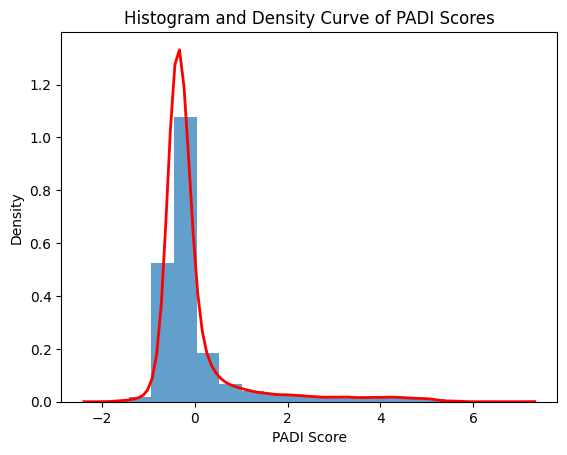

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.hist(padiScoreV1, bins=20, density=True, alpha=0.7)

# Calculate the curve (e.g., kernel density estimate)
from scipy.stats import kde
density = kde.gaussian_kde(padiScoreV1)
x_vals = np.linspace(min(padiScoreV1), max(padiScoreV1), 100)
y_vals = density(x_vals)

# Plot the curve
plt.plot(x_vals, y_vals, color='red', linewidth=2)

# Set labels and title
plt.xlabel("PADI Score")
plt.ylabel("Density")
plt.title("Histogram and Density Curve of PADI Scores")
plt.show()

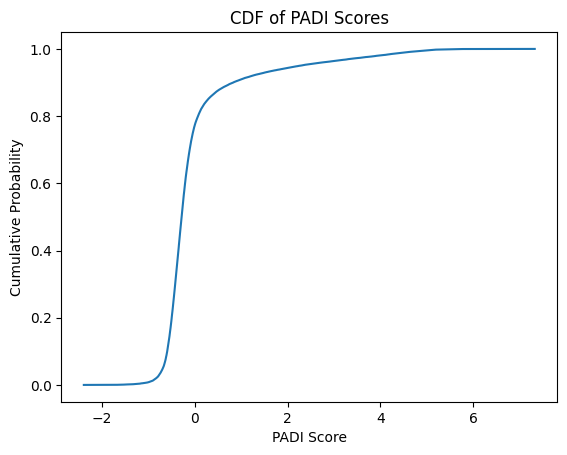

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sorted_scores = np.sort(padiScoreV1)
cdf = np.arange(len(sorted_scores)) / len(sorted_scores)
plt.plot(sorted_scores, cdf)
plt.xlabel("PADI Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of PADI Scores")
plt.show()

## Pipeline for indexing:

training indices -> loci -> loci value to padi score


In [17]:
yTrainRegression = []
for i in indsTrainV1:
  padi_score_at_i = padiScoreV1[i]
  yTrainRegression.append(padiScoreV1[i])

yTrainRegression = np.array(yTrainRegression)

In [18]:
yTrainRegression

array([-0.45692011,  4.86532619, -0.39495881, ..., -0.73664492,
       -0.62433538, -0.39047901])

In [19]:
yTestRegression = []
for i in indsTestV1:
  padi_score_at_i = padiScoreV1[i]
  yTestRegression.append(padiScoreV1[i])

yTestRegression = np.array(yTestRegression)

In [20]:
ground_truth = np.where(yTestRegression > 1, 'TAD', 'no TAD')


In [21]:
yValRegression = []
for i in indsValV1:
  padi_score_at_i = padiScoreV1[i]
  yValRegression.append(padiScoreV1[i])

yValRegression = np.array(yValRegression)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Create a scaler object
scaler = RobustScaler()

# Fit the scaler to your training data
scaler.fit(yTrainRegression.reshape(-1, 1))  # Reshape to a 2D array

# Transform your training and other data
yTrainRegression = scaler.transform(yTrainRegression.reshape(-1, 1))
yValRegression = scaler.transform(yValRegression.reshape(-1, 1))
yTestRegression = scaler.transform(yTestRegression.reshape(-1, 1))

In [22]:
yTrainRegression

array([-0.45692011,  4.86532619, -0.39495881, ..., -0.73664492,
       -0.62433538, -0.39047901])

## Running the model taken from https://github.com/LisaVdB/TADA/blob/main/src/Training.py

In [25]:
import csv
import numpy as np
import pandas as pd
from pickle import dump, load
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.utils import class_weight

np.random.seed(1258)  # for reproducibility


'''
loading saved-data batch
'''

# change last folder name by respective batches
save_file_path = 'shail'

# Create and train the model
model = create_model()
model.summary()

history = History()
# model_checkpoint = ModelCheckpoint(filepath = save_file_path + 'checkpoints/tada.{epoch:02d}-{val_loss:.2f}.hdf5',\
#         save_weights_only=True,\
#             monitor='val_loss',\
#                 mode='auto',\
#                     save_best_only=True)
earlystopper = EarlyStopping(monitor='val_f1_metric', patience=7, verbose=1,mode="max")

callbacks = [
    history,
    # model_checkpoint,
    earlystopper
]

Creating model...


/Users/shailshah/Desktop/Aage/TADA_T2/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 35, 100)        │         8,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 35, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 34, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 34, 100)        │           134 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 34, 200)        │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,535 (1.64 MB)

 Trainable params: 430,535 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

## Observation:
1. Using normal y values gave

- Test Loss (MSE): 0.9841445684432983

- Test Mean Absolute Error (MAE): 0.5771554112434387
2. Using StandardScaler and MinMaxScaler also gave results similar to this
3. Using RobustScaler gave
- Test Loss (MSE): 2.316943883895874
- Test Mean Absolute Error (MAE): 1.2272250652313232
4. Logarithmic RobustScaler:
- Test Loss (MSE): 3.2900633811950684
- Test Mean Absolute Error (MAE): 1.012035846710205

In [26]:
history = model.fit(xTrainV1, yTrainRegression, batch_size=128, #[64,128]
                    epochs=20, verbose=1, callbacks=callbacks,
                    validation_data=(xValV1, yValRegression))


Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - loss: 1.0642 - mae: 0.6225 - val_loss: 0.9847 - val_mae: 0.5813
Epoch 2/20
  2/377 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - loss: 0.7833 - mae: 0.5334 

/Users/shailshah/Desktop/Aage/TADA_T2/venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_metric` which is not available. Available metrics are: loss,mae,val_loss,val_mae
  current = self.get_monitor_value(logs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 1.0014 - mae: 0.5818 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.9879 - mae: 0.5818 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 1.0006 - mae: 0.5824 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.9970 - mae: 0.5812 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.9938 - mae: 0.5827 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 0.9973 - mae: 0.5810 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 0.9991 - mae: 0.5829 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 9/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - loss: 1.0230 - mae: 0.5866 - val_loss: 0.9835 - val_mae: 0.5813
Epoch 10/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/s

In [28]:
import tensorflow as tf

# List all available devices
devices = tf.config.list_physical_devices()
print("Available devices:", devices)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU")
else:
    print("Running on CPU")


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Running on CPU


In [32]:
import tensorflow as tf
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: []


In [ ]:
model.save('/content/drive/MyDrive/transfer/shail/regression_tada_log.h5')

In [ ]:
model.save('/content/drive/MyDrive/transfer/shail/regression_tada_log.keras')

## Linear RobustScaler





In [ ]:
from keras.models import load_model

# Load your model
model = load_model('/content/drive/MyDrive/transfer/shail/regression_tada_linear_robust.keras', custom_objects={'Attention': Attention})

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
initial_predictions = model.predict(xTrainV1[:10])
print("Initial predictions:", initial_predictions)
print("Real predictions:", yTrainRegression[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Initial predictions: [[ 0.20365149]
 [ 9.882366  ]
 [-0.09688766]
 [ 0.17152831]
 [ 0.3135509 ]
 [-0.08685862]
 [ 7.448575  ]
 [ 1.3793681 ]
 [ 0.06814274]
 [-0.1093253 ]]
Real predictions: [[-0.41278026]
 [12.33517279]
 [-0.26436927]
 [-0.65516354]
 [ 0.10373415]
 [-0.52532886]
 [10.74200338]
 [ 0.05769122]
 [ 0.13841441]
 [-0.72713496]]


In [ ]:
test_loss, test_mae = model.evaluate(xTestV1, yTestRegression, verbose=0)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
# print(f"Test Validation Loss (MSE): {test_val_loss}")
# print(f"Test Validation Mean Absolute Error (MAE): {test_val_mae}")

# Make predictions on the test set
y_pred = model.predict(xTestV1)
y_pred = scaler.inverse_transform(y_pred)
# --- Plotting Graphs ---

import matplotlib.pyplot as plt

# 1. Plot Training History (Loss)
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss (MSE)')
# plt.legend()
# plt.show()

# # 2. Plot Predicted vs. Actual Values
# plt.figure(figsize=(10, 6))
# plt.scatter(yTestRegression, y_pred, alpha=0.5)  # Scatter plot
# # plt.plot([yTestRegression.min(), yTestRegression.max()], [yTestRegression.min(), yTestRegression.max()], 'r--', label='Perfect Prediction')  # Line of perfect prediction
# plt.title('Predicted vs. Actual Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.legend()
# plt.show()

Test Loss (MSE): 3.209538221359253
Test Mean Absolute Error (MAE): 1.0384163856506348
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
import numpy as np

# Assuming 'predictions' is the variable containing your model's predictions
classifications = np.where(y_pred > 1, 'TAD', 'no TAD')

no_tad_count = np.count_nonzero(classifications == 'no TAD')
tad_count = np.count_nonzero(classifications == 'TAD')

print(f"Number of 'no TADs': {no_tad_count}")
print(f"Number of 'TADs': {tad_count}")


Number of 'no TADs': 6293
Number of 'TADs': 576


In [ ]:
import numpy as np

threshold = 1  # Set your threshold for TAD/no TAD classification
y_pred_class = np.where(y_pred > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

# Assuming 'yTestRegression' contains your true labels (ground truth)
y_true_class = np.where(yTestRegression > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true_class, y_pred_class)
print(f"F1 Score: {f1}")

F1 Score: 0.47123893805309736


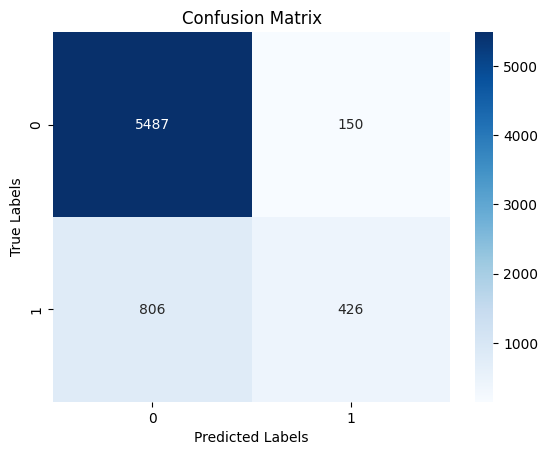

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-54-542abd839b2e>:12: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density = kde.gaussian_kde(padiScoreV1)
<ipython-input-54-542abd839b2e>:19: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density_pred = kde.gaussian_kde(y_pred.reshape(-1))


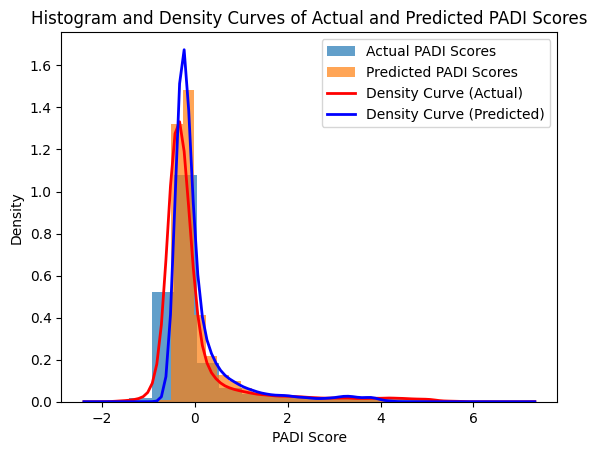

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.hist(padiScoreV1, bins=20, density=True, alpha=0.7, label='Actual PADI Scores')

# Create the histogram for predicted PADI scores
plt.hist(y_pred, bins=20, density=True, alpha=0.7, label='Predicted PADI Scores')

# Calculate the curve (e.g., kernel density estimate)
from scipy.stats import kde
density = kde.gaussian_kde(padiScoreV1)
x_vals = np.linspace(min(padiScoreV1), max(padiScoreV1), 100)
y_vals = density(x_vals)

plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Density Curve (Actual)')

# Calculate density for predicted scores
density_pred = kde.gaussian_kde(y_pred.reshape(-1))
y_vals_pred = density_pred(x_vals)

# Plot the curve for predicted PADI scores
plt.plot(x_vals, y_vals_pred, color='blue', linewidth=2, label='Density Curve (Predicted)')

# Set labels, title, and legend
plt.xlabel("PADI Score")
plt.ylabel("Density")
plt.title("Histogram and Density Curves of Actual and Predicted PADI Scores")
plt.legend()
plt.show()

## Logarithmic RobustScaler

In [ ]:
from keras.models import load_model

# Load your model
model = load_model('/content/drive/MyDrive/transfer/shail/regression_tada_log_robust.keras', custom_objects={'Attention': Attention})

In [ ]:
initial_predictions = model.predict(xTrainV1[:10])
print("Initial predictions:", initial_predictions)
print("Real predictions:", yTrainRegression[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Initial predictions: [[1.1870472e-01]
 [1.2018889e+01]
 [1.6899109e-02]
 [1.4148837e-01]
 [1.9881356e-01]
 [1.0932460e-02]
 [5.6174421e+00]
 [6.0064381e-01]
 [1.3558325e-02]
 [1.9249432e-02]]
Real predictions: [[-0.41278026]
 [12.33517279]
 [-0.26436927]
 [-0.65516354]
 [ 0.10373415]
 [-0.52532886]
 [10.74200338]
 [ 0.05769122]
 [ 0.13841441]
 [-0.72713496]]


In [ ]:
test_loss, test_mae = model.evaluate(xTestV1, yTestRegression, verbose=0)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
# print(f"Test Validation Loss (MSE): {test_val_loss}")
# print(f"Test Validation Mean Absolute Error (MAE): {test_val_mae}")

# Make predictions on the test set
y_pred = model.predict(xTestV1)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# --- Plotting Graphs ---

import matplotlib.pyplot as plt

# 1. Plot Training History (Loss)
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss (MSE)')
# plt.legend()
# plt.show()

# # 2. Plot Predicted vs. Actual Values
# plt.figure(figsize=(10, 6))
# plt.scatter(yTestRegression, y_pred, alpha=0.5)  # Scatter plot
# plt.plot([yTestRegression.min(), yTestRegression.max()], [yTestRegression.min(), yTestRegression.max()], 'r--', label='Perfect Prediction')  # Line of perfect prediction
# plt.title('Predicted vs. Actual Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.legend()
# plt.show()

Test Loss (MSE): 3.2900633811950684
Test Mean Absolute Error (MAE): 1.012035846710205
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
import numpy as np

# Assuming 'predictions' is the variable containing your model's predictions
classifications = np.where(y_pred > 1, 'TAD', 'no TAD')

no_tad_count = np.count_nonzero(classifications == 'no TAD')
tad_count = np.count_nonzero(classifications == 'TAD')

print(f"Number of 'no TADs': {no_tad_count}")
print(f"Number of 'TADs': {tad_count}")


Number of 'no TADs': 6379
Number of 'TADs': 490


Ground Truth:

Number of 'no TADs': 5746

Number of 'TADs': 1123

In [ ]:
import numpy as np

threshold = 1  # Set your threshold for TAD/no TAD classification
y_pred_class = np.where(y_pred > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

# Assuming 'yTestRegression' contains your true labels (ground truth)
y_true_class = np.where(yTestRegression > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true_class, y_pred_class)
print(f"F1 Score: {f1}")

F1 Score: 0.43205574912891986


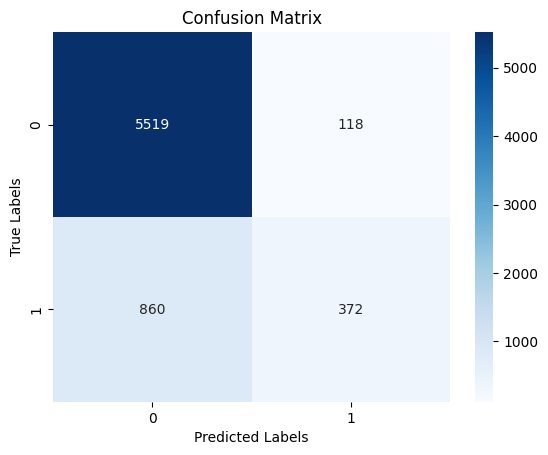

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-46-542abd839b2e>:12: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density = kde.gaussian_kde(padiScoreV1)
<ipython-input-46-542abd839b2e>:19: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density_pred = kde.gaussian_kde(y_pred.reshape(-1))


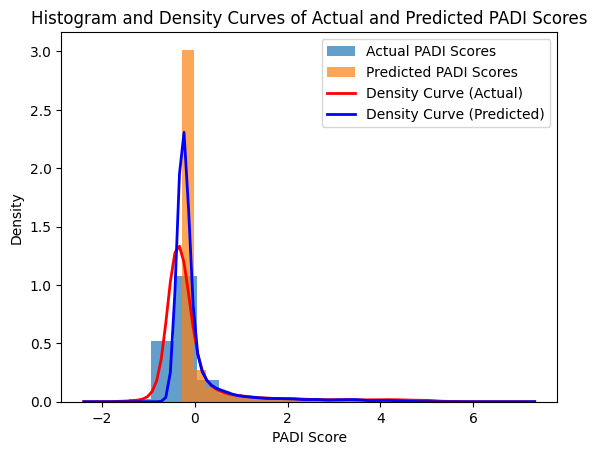

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.hist(padiScoreV1, bins=20, density=True, alpha=0.7, label='Actual PADI Scores')

# Create the histogram for predicted PADI scores
plt.hist(y_pred, bins=20, density=True, alpha=0.7, label='Predicted PADI Scores')

# Calculate the curve (e.g., kernel density estimate)
from scipy.stats import kde
density = kde.gaussian_kde(padiScoreV1)
x_vals = np.linspace(min(padiScoreV1), max(padiScoreV1), 100)
y_vals = density(x_vals)

plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Density Curve (Actual)')

# Calculate density for predicted scores
density_pred = kde.gaussian_kde(y_pred.reshape(-1))
y_vals_pred = density_pred(x_vals)

# Plot the curve for predicted PADI scores
plt.plot(x_vals, y_vals_pred, color='blue', linewidth=2, label='Density Curve (Predicted)')

# Set labels, title, and legend
plt.xlabel("PADI Score")
plt.ylabel("Density")
plt.title("Histogram and Density Curves of Actual and Predicted PADI Scores")
plt.legend()
plt.show()

## Trying Polynomial Regression

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [ ]:
degree = 2  # Set the degree of the polynomial (e.g., 2 for quadratic)
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

In [ ]:
num_samples = xTrainV1.shape[0]  # Get the number of samples
num_features = xTrainV1.shape[1] * xTrainV1.shape[2]  # Calculate total features
xTrainV1_reshaped = xTrainV1.reshape(num_samples, num_features)

In [ ]:
yTrainRegression = yTrainRegression.reshape(-1)
yValRegression = yValRegression.reshape(-1)
yTestRegression = yTestRegression.reshape(-1)

In [ ]:
polyreg.fit(xTrainV1_reshaped, yTrainRegression)

In [ ]:
xTestV1_reshaped = xTestV1.reshape(xTestV1.shape[0], xTestV1.shape[1] * xTestV1.shape[2])

In [ ]:
y_pred = polyreg.predict(xTestV1_reshaped)

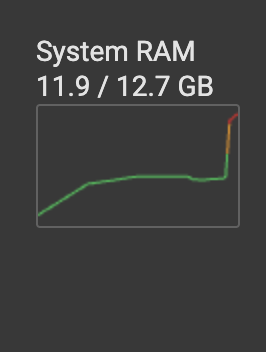

Result: Failed due to running out of memory and crashing in runtime

## Linear unscaled

In [ ]:
from keras.models import load_model

# Load your model
model = load_model('/content/drive/MyDrive/transfer/shail/regression_tada.keras', custom_objects={'Attention': Attention})

In [ ]:
test_loss, test_mae = model.evaluate(xTestV1, yTestRegression, verbose=0)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
# print(f"Test Validation Loss (MSE): {test_val_loss}")
# print(f"Test Validation Mean Absolute Error (MAE): {test_val_mae}")

# Make predictions on the test set
y_pred = model.predict(xTestV1)

# # --- Plotting Graphs ---

# import matplotlib.pyplot as plt

# # 1. Plot Training History (Loss)
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss (MSE)')
# plt.legend()
# plt.show()

# # 2. Plot Predicted vs. Actual Values
# plt.figure(figsize=(10, 6))
# plt.scatter(yTestRegression, y_pred, alpha=0.5)  # Scatter plot
# plt.plot([yTestRegression.min(), yTestRegression.max()], [yTestRegression.min(), yTestRegression.max()], 'r--', label='Perfect Prediction')  # Line of perfect prediction
# plt.title('Predicted vs. Actual Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.legend()
# plt.show()

Test Loss (MSE): 1.7734248638153076
Test Mean Absolute Error (MAE): 0.8515610694885254
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
import numpy as np

# Assuming 'predictions' is the variable containing your model's predictions
classifications = np.where(y_pred > 1, 'TAD', 'no TAD')

In [ ]:
no_tad_count = np.count_nonzero(classifications == 'no TAD')
tad_count = np.count_nonzero(classifications == 'TAD')

print(f"Number of 'no TADs': {no_tad_count}")
print(f"Number of 'TADs': {tad_count}")


Number of 'no TADs': 5746
Number of 'TADs': 1123


Ground Truth:

Number of 'no TADs': 5746

Number of 'TADs': 1123


In [ ]:
import numpy as np

threshold = 1  # Set your threshold for TAD/no TAD classification
y_pred_class = np.where(y_pred > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

# Assuming 'yTestRegression' contains your true labels (ground truth)
y_true_class = np.where(yTestRegression > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true_class, y_pred_class)
print(f"F1 Score: {f1}")

F1 Score: 0.5034403669724771


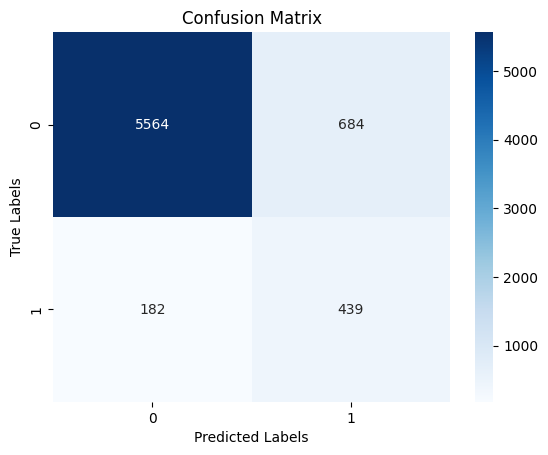

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Logarithmic Unscaled

In [ ]:
from keras.models import load_model

# Load your model
model = load_model('/content/drive/MyDrive/transfer/shail/regression_tada_log.keras', custom_objects={'Attention': Attention})

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test Loss (MSE): 0.9841786026954651
Test Mean Absolute Error (MAE): 0.5800721049308777
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


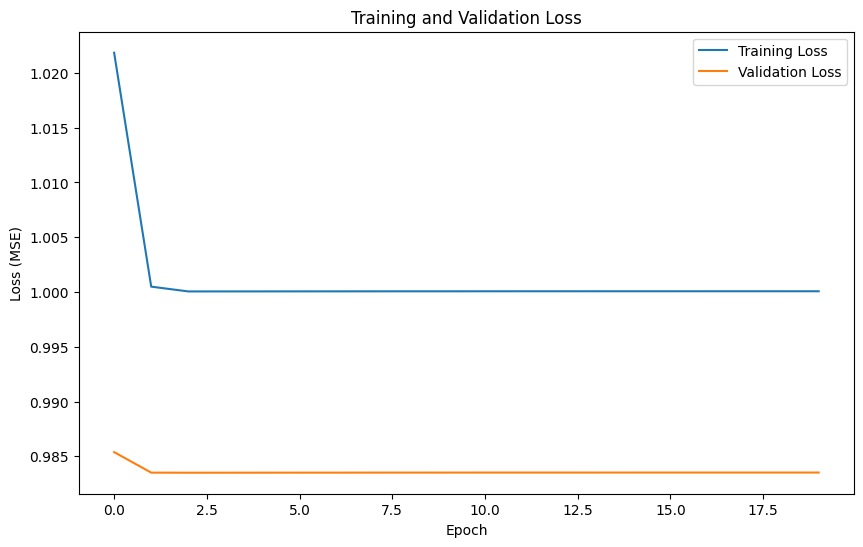

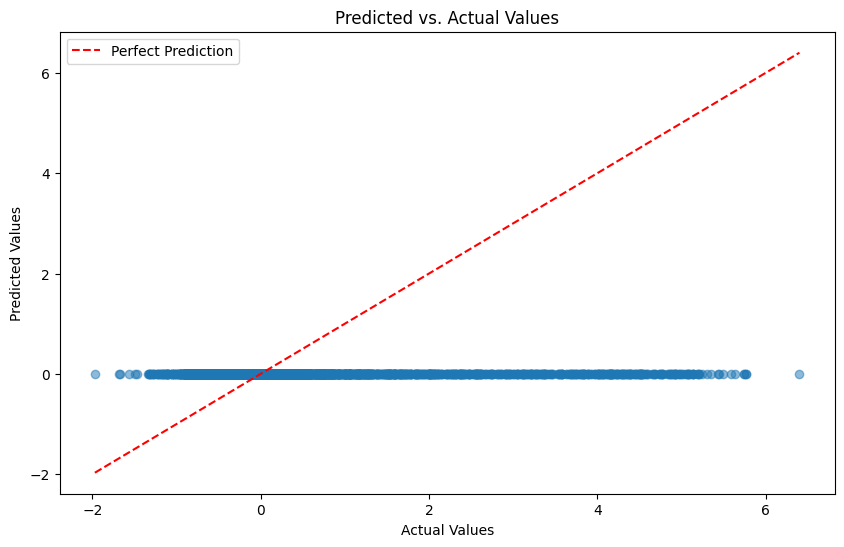

In [ ]:
test_loss, test_mae = model.evaluate(xTestV1, yTestRegression, verbose=0)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
# print(f"Test Validation Loss (MSE): {test_val_loss}")
# print(f"Test Validation Mean Absolute Error (MAE): {test_val_mae}")

# Make predictions on the test set
y_pred = model.predict(xTestV1)

# --- Plotting Graphs ---

import matplotlib.pyplot as plt

# 1. Plot Training History (Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 2. Plot Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(yTestRegression, y_pred, alpha=0.5)  # Scatter plot
plt.plot([yTestRegression.min(), yTestRegression.max()], [yTestRegression.min(), yTestRegression.max()], 'r--', label='Perfect Prediction')  # Line of perfect prediction
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Assuming 'predictions' is the variable containing your model's predictions
classifications = np.where(y_pred > 1, 'TAD', 'no TAD')

In [ ]:
no_tad_count = np.count_nonzero(classifications == 'no TAD')
tad_count = np.count_nonzero(classifications == 'TAD')

print(f"Number of 'no TADs': {no_tad_count}")
print(f"Number of 'TADs': {tad_count}")

Number of 'no TADs': 6869
Number of 'TADs': 0


In [ ]:
import numpy as np

threshold = 1  # Set your threshold for TAD/no TAD classification
y_pred_class = np.where(y_pred > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

# Assuming 'yTestRegression' contains your true labels (ground truth)
y_true_class = np.where(yTestRegression > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true_class, y_pred_class)
print(f"F1 Score: {f1}")

F1 Score: 0.0


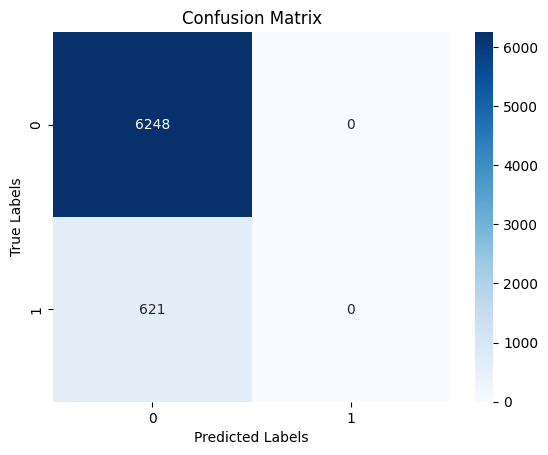

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Random Guessing

In [ ]:
import numpy as np

def random_guessing_regressor(y_train, y_test):
  """
  Predicts random values within the range of the training data.

  Args:
      y_train: The training target values (used to determine the range).
      y_test: The test data for which to make predictions.

  Returns:
      y_pred: The random predictions for the test data.
  """
  # Get the minimum and maximum values from the training target
  min_val = y_train.min()
  max_val = y_train.max()

  # Generate random predictions within the range for the test data
  num_test_samples = y_test.shape[0]  # Number of test samples
  y_pred = np.random.uniform(low=min_val, high=max_val, size=num_test_samples)

  return y_pred


In [ ]:
y_pred = random_guessing_regressor(yTrainRegression, yTestRegression)

In [ ]:
import numpy as np

threshold = 1  # Set your threshold for TAD/no TAD classification
y_pred_class = np.where(y_pred > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

# Assuming 'yTestRegression' contains your true labels (ground truth)
y_true_class = np.where(yTestRegression > threshold, 1, 0)  # 1 for TAD, 0 for no TAD

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true_class, y_pred_class)
print(f"F1 Score: {f1}")

F1 Score: 0.1669613042624239


In [ ]:
import numpy as np

# Assuming 'predictions' is the variable containing your model's predictions
classifications = np.where(y_pred > 1, 'TAD', 'no TAD')


In [ ]:
no_tad_count = np.count_nonzero(classifications == 'no TAD')
tad_count = np.count_nonzero(classifications == 'TAD')

print(f"Number of 'no TADs': {no_tad_count}")
print(f"Number of 'TADs': {tad_count}")

Number of 'no TADs': 2399
Number of 'TADs': 4470


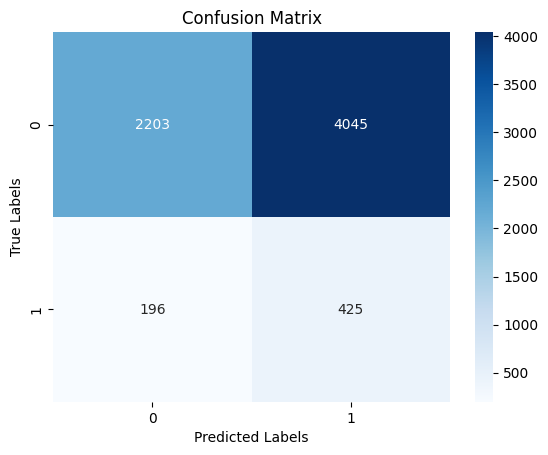

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()